# Mutual inclinations of binary stars and their circumbinary disks

*This is a notebook exploring some concepts in a paper we are working on about circumbinary disks.*

Here's what seems like a pretty straightforward question that turns out to have not-such-a-straightforward answer. Let's say we have measurements of the inclination of a binary star orbit and its circumbinary disk relative to the sky plane, $i_\star$ and $i_\mathrm{disk}$. And, let's say that these are pretty similar, like $i_\star = 33.42^\circ \pm 0.01^\circ$ and $i_\mathrm{disk} = 33.5^\circ \pm 1.4^\circ$ (as in V4046 Sgr system, [for example](https://ui.adsabs.harvard.edu/#abs/2012ApJ...759..119R/abstract)). How misaligned are the circumbinary disk and the plane of the binary orbit, i.e., what's their mutual inclination? You might say the fact that

$$
|i_\mathrm{disk} - i_\star| = |33.5^\circ - 33.42^\circ| < 0.1^\circ
$$

means that these planes are pretty much coplanar. However, that's not the full story because $i$ just tells us the inclination of each orbit relative to the sky plane and we need to know the position angle of the ascending node $\Omega$ to actually visualize the orbit in 3D space. Given both measurements of $i$ and $\Omega$ for both the binary star orbit and its circumbinary disk, we can calculate the mutual inclination $\Delta I$ between the two as

$$
\cos (\Delta I) = \cos i_\mathrm{disk} \cos i_\star + \sin i_\mathrm{disk} \sin i_\star \cos(\Omega_\mathrm{disk} - \Omega_\star).
$$

For a growing sample of binary stars with double-lined radial velocity solutions and circumbinary protoplanetary disks resolved by ALMA, we generally have precise constraints on $i_\mathrm{disk}$, $\Omega_\mathrm{disk}$, and $i_\star$, but no constraint on $\Omega_\star$. Therefore, we are unable to directly solve for $\Delta I$. 

To make this problem concrete, let's consider V4046 Sgr, which in addition to the inclinations quoted, also has $\Omega_\mathrm{disk} = 256^\circ \pm 1.0^\circ$. Our goal is to use the measurements of these three parameters to determine the posterior probability distribution of the mutual inclination. 

First, we'll walk through the example of V4046 Sgr using a typical Bayesian approach making what seem like reasonable assumptions, and end up with a counter-intuitive result. Then, we'll introduce a hierarchical model that includes a parameterization of the mutual inclination distribution. To test this, we'll make two samples of fake data, one with intrinsically low mutual inclinations and one with isotropically randomly oriented orbits. Finally, we'll use our model to see if we recover the input distributions. 

## Isotropic priors

For any isotropically oriented orbit in 3D space, the prior probability distribution on the pair of parameters is

$$
p(i, \Omega) = \frac{\sin i}{2}.
$$

Assuming a uniform prior $\Omega_\star$ we can go through the process of translating these measurements into a constraint on $\Delta I$. 

Let's start by importing some packages that will help us solve this problem, such as the normal ones like numpy and matplotlib, but also PyMC3 and Theano (it's foundation).

In [1]:
# code here
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

import numpy as np
import theano.tensor as tt
import pymc3 as pm

import matplotlib.pyplot as plt

deg = np.pi/180.0

## V4046 Sgr

Taking the parameters from Rosenfeld et al. 2012



**Here we'll add in some short notes and example code about getting the answer that points to a large bias in the parameters.**

For any one disk, this result makes sense. Without a measurement of $\Omega_\star$, we can't actually say what the mutual inclination is, other than an upper limit. 


While such a conclusion is perhaps inevitiable on a disk-by-disk basis, there arrises a paradox when we consider a collection of disks. Let's say we had a sample of 5 disks, and they all had $i_\mathrm{disk} \approx i_\star$. We would suspect that there is some sort of alignment in 3D space, because if there wasn't, we would have already seen at least a few disks with $i_\mathrm{disk} \ne i_\star$ in this sample. 

The reason this occurs is because the maximum likelihood estimator for $\Delta I$ is biased. One way around this is to consider a hierarchical Bayesian model for the population of 5 disks, where we seek to infer the distribution function of mutual inclinations.

In [ ]:
# Define the likelihood by conditioning on the observations 
data = np.array([np.cos(33.5 * deg), 256.0 * deg, np.cos(33.42 * deg)])
    
# converting the uncertainty requires a change of variables 
# sigma_cos_i = sin(i) * sigma_i (where sigma_i is in radians)
sigma = np.array([ np.sin(33.5 * deg) * 1.4 * deg, 1.0 * deg, np.sin(33.42 * deg) * 0.01 * deg])

In [ ]:
# instantiate a PyMC3 model class 
with pm.Model() as model:
    
    # priors on i_disk, Omega_disk, i_star, Omega_star
    # everything's assumed to be in radians
    # a uniform prior on cos(i) means p(i) = sin(i)
    cos_i_disk = pm.Uniform("cosIdisk", lower=-1.0, upper=1.0)
    Omega_disk = pm.Uniform("OmegaDisk", lower=0.0, upper=2*np.pi)
     
    cos_i_star = pm.Uniform("cosIstar", lower=-1.0, upper=1.0)
    Omega_star = pm.Uniform("OmegaStar", lower=0.0, upper=2*np.pi)
    
    # calculate the intermediate quantities for determining mutual inclination
    # to go from cos(i) -> sin(i), do 
    sin_i_disk = tt.sqrt(1.0 - cos_i_disk**2)
    sin_i_star = tt.sqrt(1.0 - cos_i_star**2)
        
    # store Delta I as a deterministic byproduct
    cos_Delta_I = pm.Deterministic("cosDeltaI", cos_i_disk * cos_i_star + \
                               sin_i_disk * sin_i_star * tt.cos(Omega_disk - Omega_star))

    # assemble a vector to compare to the observations
    mu = [cos_i_disk, Omega_disk, cos_i_star]
    obs = pm.Normal("obs", mu=mu, sd=sigma, observed=data)
    

In [ ]:
# sample the model!
with model:
    trace = pm.sample(draws=1000, tune=2000, chains=2)

In [ ]:
# visualize output
pm.summary(trace)

In [ ]:
pm.traceplot(trace)

In [ ]:
samples = pm.trace_to_dataframe(trace, varnames=["cosIdisk", "OmegaDisk", "cosIstar", "OmegaStar", "cosDeltaI"])

In [ ]:
asamples = samples.copy()
asamples.rename(index=str, columns={"cosIdisk":"iDisk", "cosIstar":"iStar", "cosDeltaI":"deltaI"}, inplace=True);

In [ ]:
icos2deg = lambda x: np.arccos(x)/deg

asamples["iDisk"] = asamples["iDisk"].apply(icos2deg)
asamples["OmegaDisk"] = asamples["OmegaDisk"] / deg
asamples["iStar"] = asamples["iStar"].apply(icos2deg)
asamples["OmegaStar"] = asamples["OmegaStar"] / deg
asamples["deltaI"] = asamples["deltaI"].apply(icos2deg)

In [ ]:
import corner  


corner.corner(asamples) #, truths=[true_m, true_b, true_logs]);

Clearly this result is undesireable. But, nonetheless it is true, unless we measure $i_\mathrm{disk} \approx i_\star \sim 0^\circ$. In fact, as the measured inclination approaches zero, the chance becomes more likely .

# Hierarchical modeling 


Let's assume some functional form for our mutual inclination distribution $p({\Delta I})$, which describes the frequency of systems with that $\Delta I$. Possible distributions include the [beta](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Beta), the [Weibull](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Weibull), and the [gamma](https://docs.pymc.io/api/distributions/continuous.html#pymc3.distributions.continuous.Gamma).

Eugene pointed out that a desirable quality of this distribution is that (regardless of whether mutual inclinations are in general low or high) it obeys

$$
\lim_{\Delta I \to 0} p(\Delta I) = 0
$$

To understand why, think about pointing a telescope at a target at $(\alpha, \delta)$. There will always be some (small) pointing error, so we actually point at $(\alpha + \epsilon_\alpha, \delta + \epsilon_\delta)$. This means that there will *always* be some *positive* radial pointing error $\epsilon_\rho = \sqrt{\epsilon_\alpha^2 + \epsilon_\delta^2}$, and so there should be 0 probability that we point *exactly* at $(\alpha, \delta)$. For the same reason, the same criterion applies for pointing in the exact opposite direction

$$
\lim_{\Delta I \to 180^\circ} p(\Delta I) = 0
$$

Since our goal is to infer the function $p(\Delta I)$, we'll need to parameterize it with some functional form. We have the power to define our own custom function, like $\sin(\Delta I) \beta$ within [PyMC3/Theano](https://docs.pymc.io/Probability_Distributions.html), but let's see what we can do first with the built in functions.

A common go-to functional choice among hierarchical Bayesians is the $\beta$ distribution, since it's very flexible and has only two parameters, $\alpha$ and $\beta$. The fact that one of the parameters of the $\beta$ distribution is also named $\beta$ is a super confusing convention, so in what follows we'll use $p_\beta$ to refer to the distribution. The PDF is 

$$
p_\beta(x |\, \alpha, \beta) = \frac{x^{\alpha - 1}(1 - x)^{\beta - 1}}{B(\alpha, \beta)}
$$
where
$$
B(\alpha, \beta) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)}
$$
and $p_\beta$ is defined over the range $[0,1]$. From the PDF, we see that if we enforce a prior that $\alpha > 1$ and $\beta > 1$, then this will give us the behavior that the probability goes to zero at the edges of the domain. As an example, here is a range of $p_\beta$ for a range of $\alpha$ and $\beta$ values. 



In [2]:
import itertools

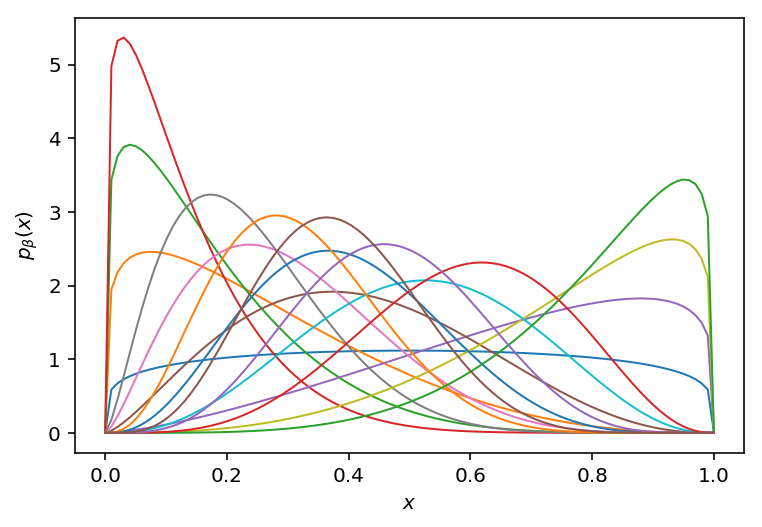

In [4]:
alphas = np.linspace(1.2, 5.0, num=4)
betas = np.linspace(1.2, 8.0, num=4)

xs = np.linspace(0, 1, num=100) # inputs 

fig, ax = plt.subplots(nrows=1)

for alpha,beta in itertools.product(alphas, betas): # plot all combinations
    y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
    ys = np.exp(np.array([y.logp(x).eval() for x in xs]))
    ax.plot(xs, ys, lw=1.0)
    
ax.set_xlabel(r"$x$");
ax.set_ylabel(r"$p_\beta(x)$");

## Setting up the hierarchical model 

Now that we've established that the $\beta$ distribution is a promising parameterization of our mutual inclination distribution, we need to do some work interfacing it to our actual problem. 

First, we'll need to transform the variable $\Delta I$ into something that fits the range $[0, 1]$. The true domain of $\Delta I$ is [0,180] degrees. We can use the variable $\cos\Delta I$, which ranges from $[-1, 1]$, and then multiply it by $1/2$ to shoehorn it into the right domain. We have

$$
x = 0.5 (1 - \cos \Delta I)
$$

where $x = 0$ is completely aligned and $x = 1$ is anti-aligned. Through this change of parameters we also need to conserve probability

$$
p(x)\,\mathrm{d}x = p(\Delta I)\,\mathrm{d} \Delta I
$$

where

$$
\mathrm{d}x = -0.5 \sin(\Delta I)\,\mathrm{d}\Delta I
$$

To put this all together, we'll say that the modified mutual inclination $x$ for any particular system is drawn from the distribution of mutual inclinations 

$$
x \sim p_\beta(\alpha, \beta)
$$

When we're doing a fit of the orbital parameters of an individual system $k$, this means we'll have prior of

$$
p_k(x_k| \alpha, \beta) = p_\beta(x_k | \alpha, \beta)
$$

In the space of actual mutual inclinations, this prior is 

$$
p_k(\Delta I) = p_k(x_k| \alpha, \beta) \frac{\mathrm{d}x}{\mathrm{d}\Delta I} = 0.5 p_\beta(0.5(1 - \cos \Delta I) | \alpha, \beta) \sin(\Delta I)
$$

### Fitting a system hierarchically 

Let's revisit the posterior distribution for the mutual inclination of a single system $k$ with this new prior. As before, our likelihood function is conditioned on all four of the quantities required to measure $\Delta I$ (and their covariances, $\boldsymbol{\Sigma}$), but is actually evaluated against only the three quantities we can measure

$$p_k( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star ) = {\cal N}( \hat{i_\mathrm{disk}}, \hat{\Omega_\mathrm{disk}}, \hat{i_\star} | i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star, \boldsymbol{\Sigma})$$

Now, rather than assuming geometric priors on $p(i, \Omega)$ for the disk and binary, we want to use the information from the $\Delta I$ prior we just specified.

**A quick note about relative angles** The mutual inclination distribution says that one plane *relative to the other* is supposed to be some value or other. So, here's what we'll do. We'll keep the prior on the orientation of the disk, 

$$
p_k(i_\mathrm{disk}, \Omega_\mathrm{disk}) = 0.5 \sin(i_\mathrm{disk})
$$

then, instead of imposing a separate geometric prior on $i_\star$ and $\Omega_\star$, instead use these values, along with the values of $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$ to calculate $\Delta I$ and impose the mutual inclination prior $p_k(\Delta I)$. All together, the full prior is

$$
p_k(i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star) = 0.5 \sin(i_\mathrm{disk}) p_k(\Delta I(i_\mathrm{disk}, \Omega_\mathrm{disk}, i_\star, \Omega_\star))
$$

As you might have suspected all along, because we don't know anything about $\Omega_\star$, whatever we measure $\Omega_\mathrm{disk}$ to be is actually irrelevant to the problem. The main quantity of interest for the mutual inclination formula is the difference between the two $\Delta \Omega = \Omega_\mathrm{disk} - \Omega_\star$. We can remove one variable from the problem if we use a "triangle" prior on this, which just results from the convolution of two top-hat functions. Or, we can even put the prior directly on $\cos(\Omega_\mathrm{disk} - \Omega_\star)$ if we want by another transformation of variables. 

The actual form of this mutual inclination prior can be phrased as 

$$
p(i_\star | i_\mathrm{disk}, \Delta \Omega)
$$

(array([1.73850001, 0.73350001, 0.5925    , 0.462     , 0.429     ,
        0.4065    , 0.3585    , 0.387     , 0.393     , 0.3285    ,
        0.3195    , 0.336     , 0.366     , 0.3015    , 0.333     ,
        0.3255    , 0.3165    , 0.33      , 0.3345    , 0.363     ,
        0.3825    , 0.3765    , 0.3585    , 0.3915    , 0.387     ,
        0.426     , 0.5205    , 0.564     , 0.69600001, 1.74300001]),
 array([-9.99999991e-01, -9.33333325e-01, -8.66666658e-01, -7.99999992e-01,
        -7.33333326e-01, -6.66666660e-01, -5.99999994e-01, -5.33333328e-01,
        -4.66666661e-01, -3.99999995e-01, -3.33333329e-01, -2.66666663e-01,
        -1.99999997e-01, -1.33333331e-01, -6.66666644e-02,  1.71809056e-09,
         6.66666679e-02,  1.33333334e-01,  2.00000000e-01,  2.66666666e-01,
         3.33333333e-01,  3.99999999e-01,  4.66666665e-01,  5.33333331e-01,
         5.99999997e-01,  6.66666663e-01,  7.33333329e-01,  7.99999996e-01,
         8.66666662e-01,  9.33333328e-01,  9.99999994e-01]

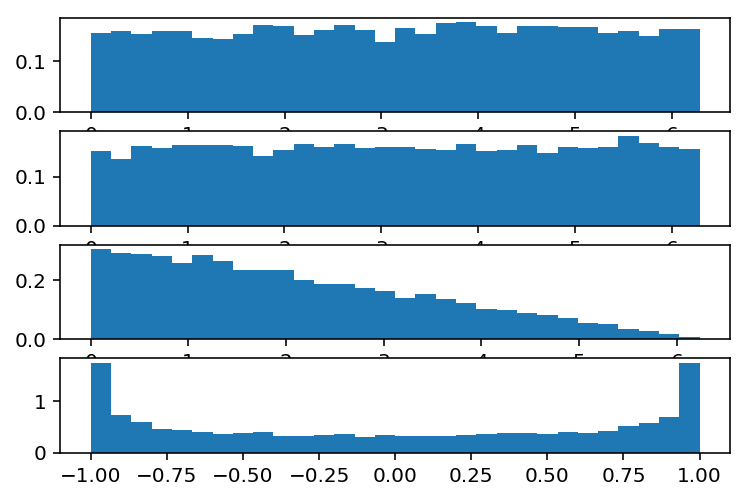

In [14]:
# In fact, we can see that here.

a = np.random.uniform(0, 2*np.pi, size=10000)
b = np.random.uniform(0, 2*np.pi, size=10000)
delta = np.abs(a - b)
cdelta = np.cos(a - b)

fig, ax = plt.subplots(nrows=4)

bins=30
ax[0].hist(a, bins=bins, density=True);
ax[1].hist(b, bins=bins, density=True);
ax[2].hist(delta, bins=bins, density=True);
ax[3].hist(cdelta, bins=bins, density=True);

All together, the final posterior for any given disk is 

$$
p_k(i_\mathrm{disk}, i_\star, \Delta \Omega | ) = {\cal N}(\hat{i}_\mathrm{disk}, \hat{i}_\star | i_\mathrm{disk}, i_\star, \boldsymbol{\Sigma}, \Delta \Omega) p(i_\mathrm{disk}) p(\Delta \Omega) p(i_\star | i_\mathrm{disk}, \Delta \Omega)
$$

Given samples from this posterior of the quantities $i_\mathrm{disk}, i_\star, \Delta \Omega$, we can use the mutual inclination formula to directly convert these to a posterior on $\Delta I$.

Of course, one of the terms in the prior $p(i_\star | i_\mathrm{disk}, \Delta \Omega)$ actually has some hidden variables. Remember that we derived this term from the prior distribution of mutual inclinations, which we parameterized with a $\beta$ distribution $p_\beta(\Delta I |\, \alpha, \beta)$. This is the hierarchical nature of the problem.

# Generating fake data

Ok, great, we have a road map of how we'd like to go about solving this problem. To unit test our assumptions, however, let's run a few fake data tests to see how well we can recover *known* distributions. We'll try out this formalism on at least two different fake datasets generated with different underlying mutual inclination distributions. 

1. A distribution with low mutual inclinations
2. A distribution with randomly isotropic binary orbits


To keep the comparison consistent, we'll first randomly draw disk orientations and then keep these fixed for both comparisons.

Generating the second distribution of binary orbits is pretty easy, these will be drawn from the same isotropic distributions as generated the disks. To generate the first distribution, however, requires a tiny bit of vector math and rotations in spherical coordinates. First, let's think about how the binary vector (i.e., the unit angular momentum vector of the orbit) would be oriented relative to the disk vector, given some mutual inclination. The mutual inclination distribution simply specifies the magnitude of the displacement of the binary vector from the disk vector, not the direction. So, to generate this distribution, we'll consider two coordinate systems, the one we've been talking about all along (relative to the observer) and a coordinate system relative to the disk (i.e., the disk vector is the north pole). 

To generate binary orbits with low mutual inclinations to the disk, we'll follow this procedure.

In the disk coordinate system,

1. Randomly generate a polar angle $\theta$ from the specified distribution of mutual inclinations $p_\beta(\alpha, \beta)$
2. Randomly generate an azimuthal angle $\phi$ from [0, 360] degrees. These angles specify the binary unit vector in the disk coordinate system.

Then, using the known orientation of the disk (from $i_\mathrm{disk}$ and $\Omega_\mathrm{disk}$) rotate the binary unit vector to the observer frame.

In [44]:
np.random.seed(42)
N_systems = 5

# let's get a sample of uniformly oriented disks in 3D space 
# Generate randomly oriented momentum vector on the sky.
U = np.random.uniform(size=N_systems)
V = np.random.uniform(size=N_systems)

# spherical coordinates for angular momentum vector, uniformly distributed.
Omega_disk = 2 * np.pi * U / deg # azimuth
i_disk = np.arccos(2 * V - 1.0) / deg # polar angle

In [60]:
for pair in zip(i_disk, Omega_disk):
    print("i_disk: {:>6.2f} deg, Omega_disk: {:>6.2f} deg".format(*pair))

i_disk: 133.47 deg, Omega_disk: 134.83 deg
i_disk: 152.11 deg, Omega_disk: 342.26 deg
i_disk:  42.92 deg, Omega_disk: 263.52 deg
i_disk:  78.33 deg, Omega_disk: 215.52 deg
i_disk:  65.41 deg, Omega_disk:  56.17 deg


Now, let's choose our two distributions on $\Delta I$. The one with close alignments

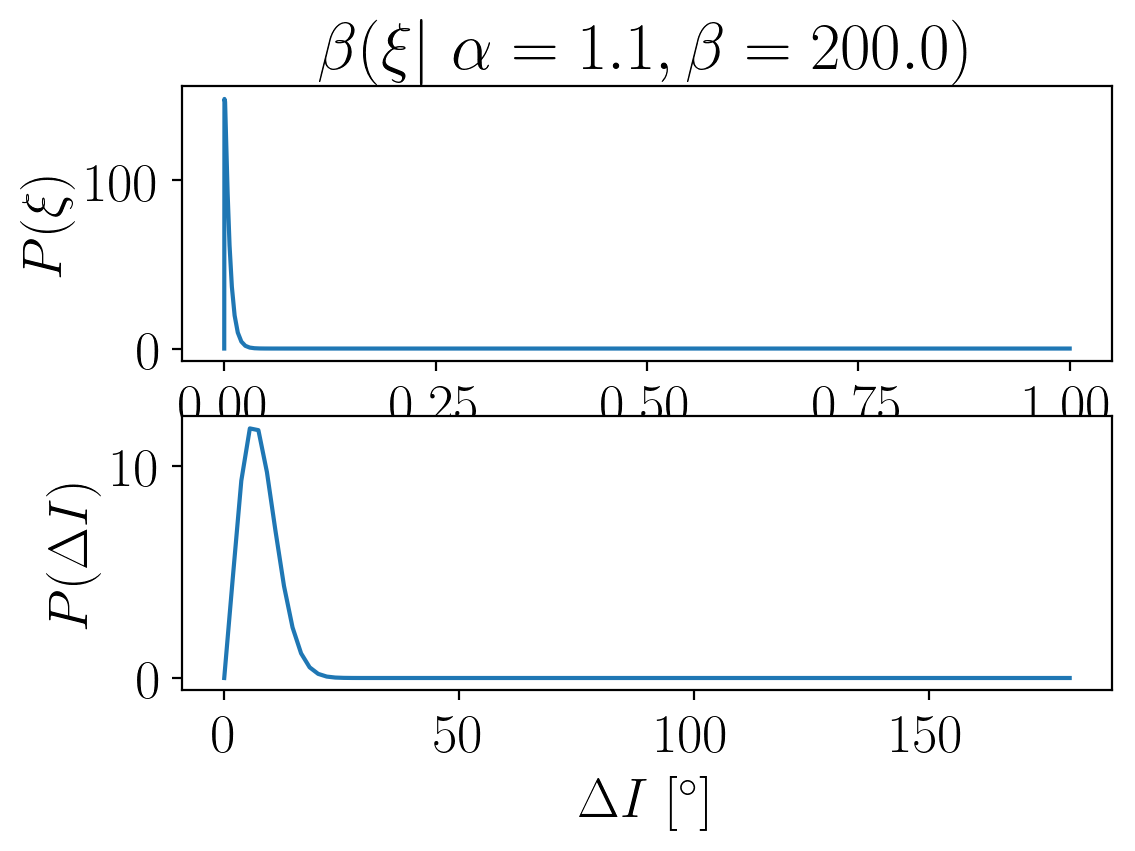

In [79]:
DeltaIs = np.linspace(0.0, 180.0, num=100) # inputs 
xis = 0.5 * (1 - np.cos(DeltaIs * deg))

fig, ax = plt.subplots(nrows=2)

alpha = 1.1
beta = 200.0
y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation
ys = np.exp(np.array([y.logp(xi).eval() for xi in xis]))
ax[0].plot(xis, ys)
    
PIs = ys * np.sin(DeltaIs * deg)
ax[1].plot(DeltaIs, PIs)    
    
ax[0].set_xlabel(r"$\xi$");
ax[0].set_ylabel(r"$P(\xi)$");
ax[0].set_title(r"$\beta(\xi |\ \alpha={:.1f}, \beta={:.1f})$".format(alpha, beta));

ax[1].set_ylabel(r"$P(\Delta I)$");
ax[1].set_xlabel(r"$\Delta I$ [${}^\circ$]");

The conversions between the two variables are
$$
\xi = 0.5 (1 - \cos \Delta I)
$$

$$
\Delta I = \cos^{-1}(1 - 2 \xi)
$$
The $\beta$ distribution does OK for this, but I guess I'd like something a bit stronger at lower mutual inclinations and a bit softer at larger mutual inclinations. Anyway, it's probably an OK start to the problem for now.

In [80]:
# let's actually draw from samples from this 
alpha = 1.1
beta = 200.0
y = pm.Beta.dist(alpha=alpha, beta=beta) # query the PyMC3 implementation

xis = y.random(size=N_systems)
DeltaIs = np.arccos(1 - 2 * xis)/deg    

for pair in zip(xis, DeltaIs):
    print(pair)
    
# Now, assume that the direction of this offset from the vector position of the disk 
# is randomly chosen from 0,360 on the unit sphere
# apply this Delta I offset from this point
# then 

(0.002043184221581926, 5.181486758714563)
(0.00571201449847902, 8.66885216413623)
(0.0008703620281001284, 3.3811591616826626)
(0.014540156307254826, 13.851451118134559)
(0.0018944931765767406, 4.989262730358599)


In [ ]:
# can we also take into account that there are possibly retrograde orbits?